# ⭐️Final Project⭐️ 
###### The final projects involve developing programs to analyze and assess the statistical significance of events in scientific data relative to a model. Detailed instructions will be provided on Canvas, and students should expect to begin working on the project starting in the 7th week of the course.

###### Use the following link to make a copy of the Google Document you will use to submit your final (remember to change the sharing permissions):

###### As you create your final project in a Jupyter notebook, you will upload your notebook to GitHub and provide the URL link to the notebook in the Google Doc. You'll submit the URL to the Google Doc as the submission to the assignment (just like with the Code Journals).


###### Final Project Instructions:

###### Steps 1-2 below are preparatory, while Steps 3-5 should appear in the Jupyter notebook uploaded to GitHub.

###### 1) Get astropy and install it on your system (pip install astropy).

###### 2) Get sep and install it on your system (pip install sep).

###### 3) Follow the tutorial found at https://sep.readthedocs.io/en/stable/tutorial.html, but use the astropy fits routines instead of fitsio. Create a notebook that performs the tutorial and comment it using Markdown to explain what it’s doing. Note that the fits image used in the tutorial can be acquired via the sep GitHub account.

###### 4) Augment the tutorial to save each of the four figures to PNG files.

###### 5) Get the f105w band image of the Hubble Ultra Deep Field, which is called: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
###### You can download it from https://archive.stsci.edu/pub/hlsp/hudf12/

###### 6) Redo the tutorial steps in a second notebook, but on the UDF f105w image. How many sources do you find? Histogram their fluxes.

###### 7) What are the mean, median, and standard deviation of the distribution of fluxes. What is the largest outlier in the distribution, where is it on the image, and how many standard deviations is it away from the mean? 

###### 8) Download the f125w and f160w images of the HUDF at the same website, and make a 3-color false image of the UDF using RGB -> f160w, f125w, f105w. Save the image as a PNG.

## Show Image
#### First, we'll read an example image from a FITS file and display it, just to show what we're dealing with.

In [4]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = [10.0,8.0]

In [5]:
# Read image into standard 2-d numpy array
hdulist1 = fits.open("image.fits")
data1 = hdulist1[0].data

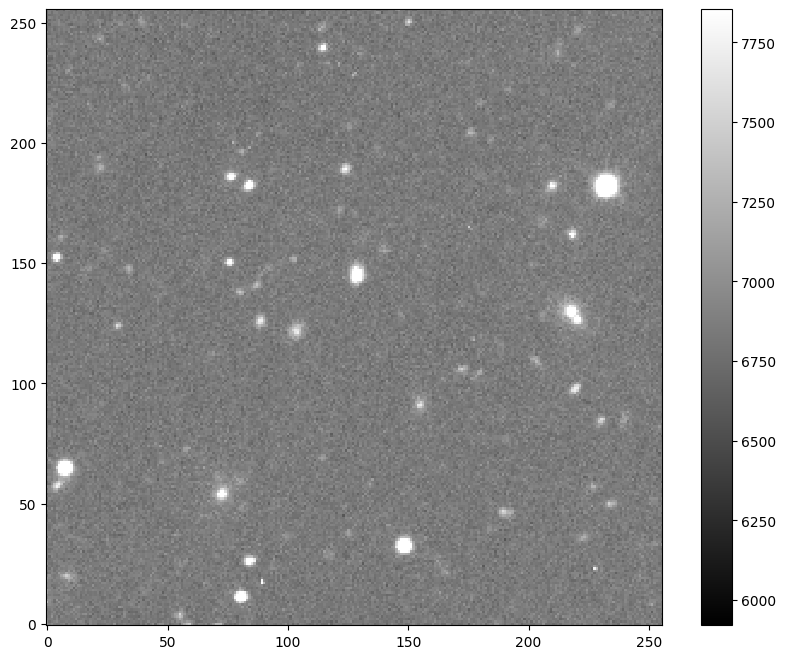

In [6]:
# Show the image
m, s = np.mean(data1), np.std(data1)
plt.imshow(data1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("image_RAW.png",bbox_inches='tight',dpi=800) # Save the image as a .png file

## Background Subtraction
#### Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two seperate steps.

In [7]:
# Measure a spatially varying background on the image
data_sep1 = data1.astype(data1.dtype.newbyteorder('=')) # Changes the byte order of the array `data` to work with SEP
bkg1 = sep.Background(data_sep1)

##### There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:

In [8]:
# bkg = sep.Background(data_sep, mask=mask, bw=64, bh=64, fw=3, fh=3)

#### This returns a Background object that holds information on spatially varying backgrounds and spatially varying background noise level. We can now do various things with this Background object:

In [9]:
# Get a "global" mean and noise of the image background:
print(bkg1.globalback)
print(bkg1.globalrms)

6852.04931640625
65.46174621582031


In [10]:
# Evaluate background as 2D array, same size as original image
bkg_image1 = bkg1.back()
# bkg_image = np.array(bkg) # equivalent to above

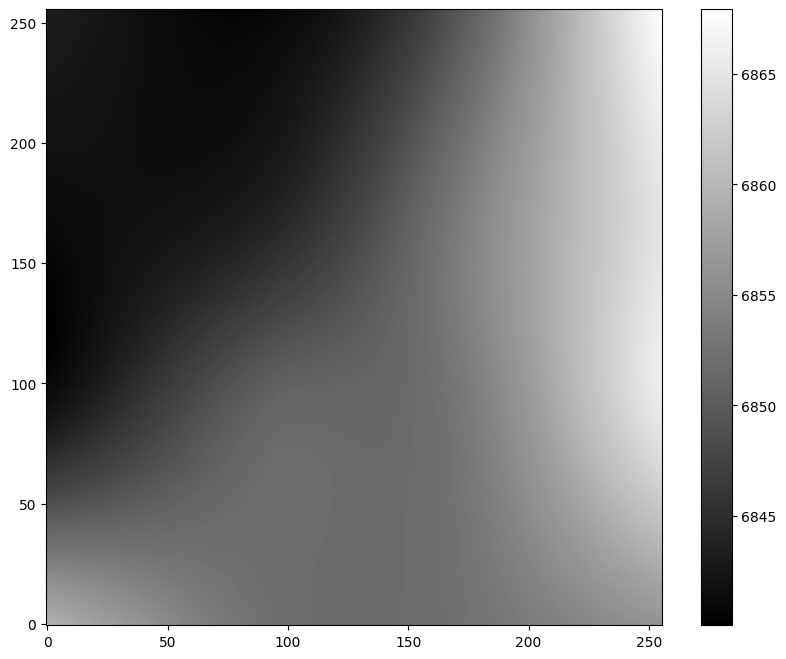

In [11]:
# Show the background
plt.imshow(bkg_image1, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("image_BACKGROUND.png",bbox_inches='tight',dpi=800) # Save the image as a .png file

In [12]:
# Evaluate the background noize as a 2D array, same size as the original image
bkg_rms1 = bkg1.rms()

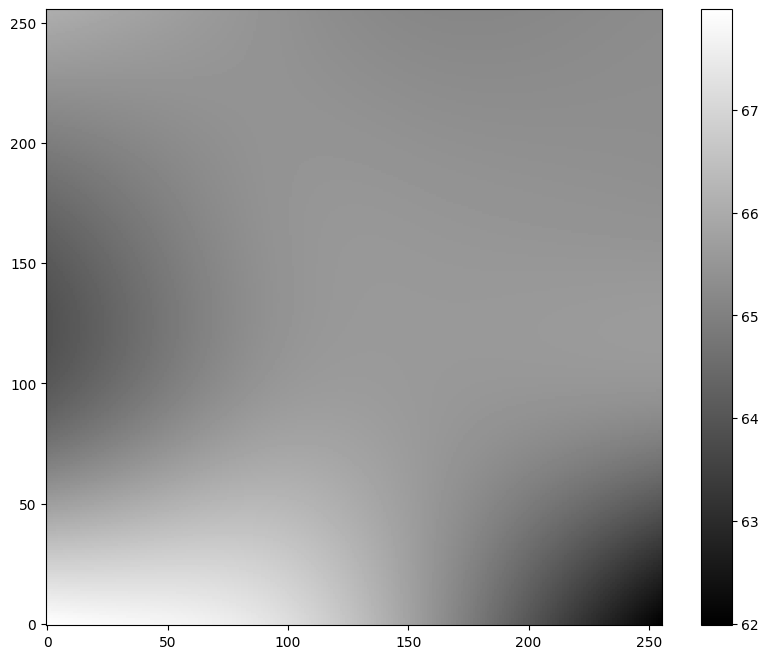

In [13]:
# Show the background noise as an image
plt.imshow(bkg_rms1, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("image_BKGNOISE.png", bbox_inches='tight',dpi=800) # Save the image as a .png file

In [14]:
# Subtract the background
data_sub1 = data1 - bkg1

#### One can also subtract the background from the data array in-place by doing bkg.subfrom(data)

## Object Detection
#### Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of 1.5sigma where sigma is the global background RMS.

In [15]:
objects1 = sep.extract(data_sub1, 1.5, err=bkg1.globalrms)

#### objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detection objects are, we'll over-plot the object coordinates with some basic shape parameters on the image:

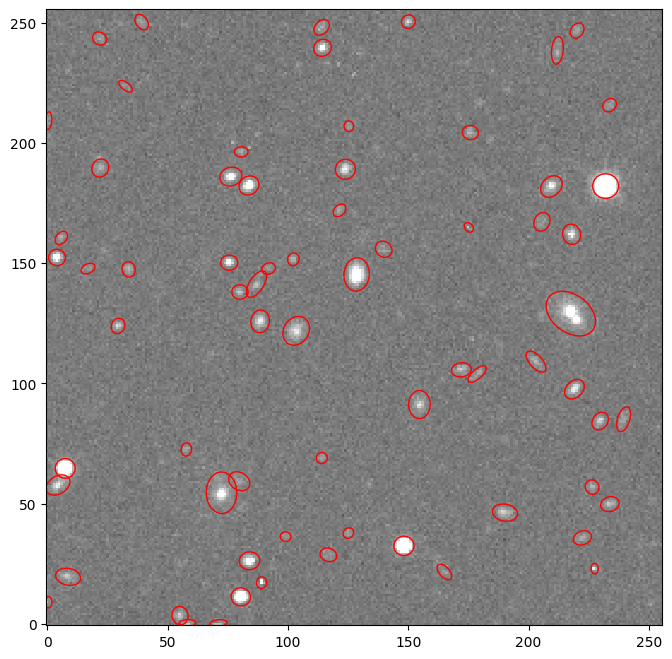

In [16]:
from matplotlib.patches import Ellipse

# Plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub1), np.std(data_sub1)
im = ax.imshow(data_sub1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Create an empty array for the x coordinates of the ellipses
ec1 = []

# Plot an ellipse for each object
for i in range(len(objects1)):
    e1 = Ellipse(xy=(objects1['x'][i], objects1['y'][i]),
                width=6*objects1['a'][i],
                height=6*objects1['b'][i],
                angle=objects1['theta'][i]*180.0/np.pi)
    e1.set_facecolor('none')
    e1.set_edgecolor('red')
    ax.add_artist(e1)
    ec1.append(objects1['x'][i]) #######################################################
    
plt.savefig("image_OBJECTS.png", bbox_inches='tight',dpi=800) # Save the image as a .png file

#### objects has many other fields, giving information such as second moments, and peak pixel positions and values. You can see the available fields:

In [17]:
# Available fields
objects1.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry
#### Finally we'll perform circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [18]:
flux1, fluxerr1, flag1 = sep.sum_circle(data_sub1, objects1['x'], objects1['y'], 3.0, err=bkg1.globalrms, gain=1.0)

#### flux, fluxerr, and flag are all 1D arrays with one entry per object.

In [19]:
# Show the first 10 object results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux1[i], fluxerr1[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138


## James Webb Data
#### Now, we shall perform the same process with data from the James Webb Telescope.

In [20]:
# Read image into standard 2-d numpy array
hdulist = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = hdulist[0].data

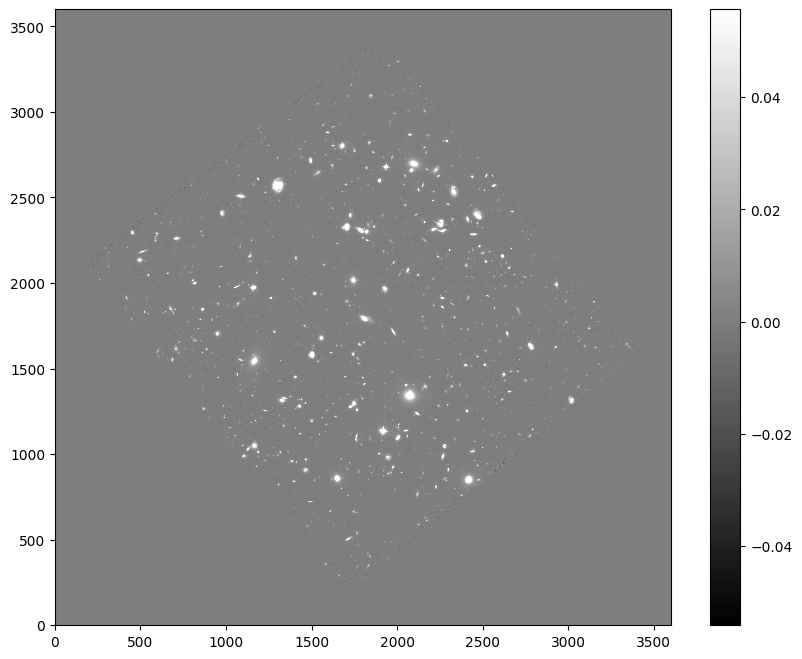

In [21]:
# Show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("f105w_v1.0_drz_RAW.png",bbox_inches='tight',dpi=800) # Save the image as a .png file

## Background Subtraction
#### Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two seperate steps.

In [22]:
# Measure a spatially varying background on the image
data_sep = data.astype(data.dtype.newbyteorder('=')) # Changes the byte order of the array `data` to work with SEP
bkg = sep.Background(data_sep)

#### This returns a Background object that holds information on spatially varying backgrounds and spatially varying background noise level. We can now do various things with this Background object:

In [23]:
# Get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [24]:
# Evaluate background as 2D array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

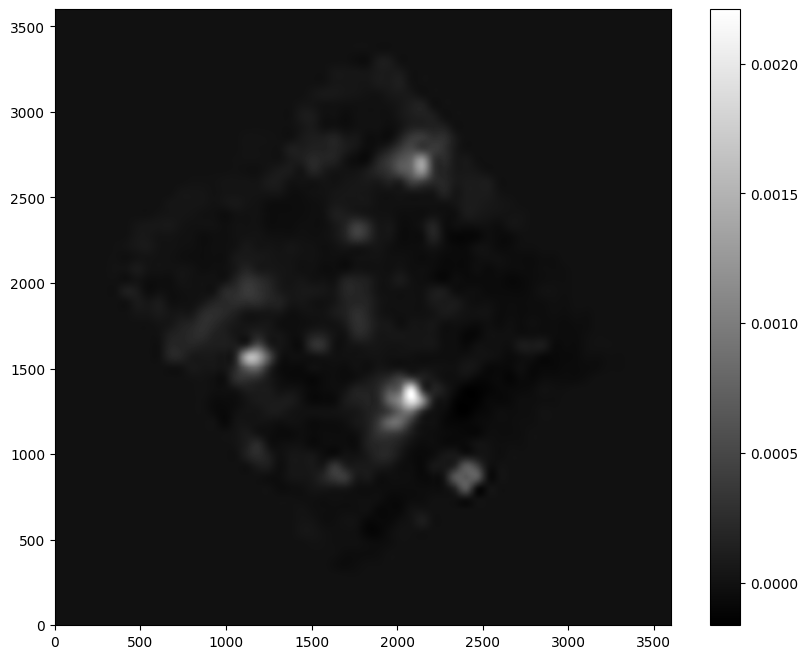

In [25]:
# Show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("f105w_v1.0_drz_BACKGROUND.png",bbox_inches='tight',dpi=800) # Save the image as a .png file

In [26]:
# Evaluate the background noize as a 2D array, same size as the original image
bkg_rms = bkg.rms()

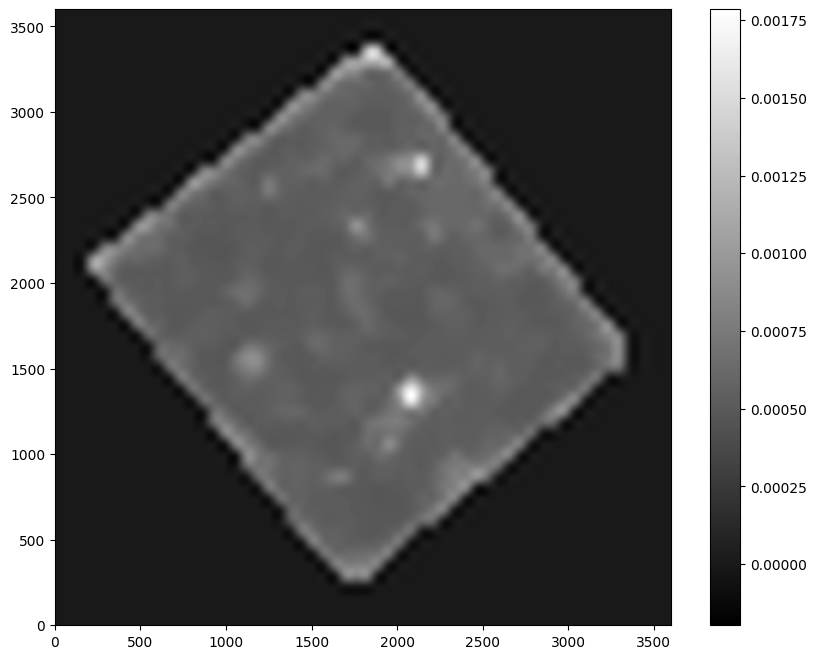

In [27]:
# Show the background noise as an image
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("f105w_v1.0_drz_BKGNOISE.png", bbox_inches='tight',dpi=800) # Save the image as a .png file

In [28]:
# Subtract the background
data_sub = data - bkg

#### One can also subtract the background from the data array in-place by doing bkg.subfrom(data)

## Object Detection
#### Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of 1.5sigma where sigma is the global background RMS.

In [29]:
objects = sep.extract(data_sub, 5, err=bkg.globalrms)
print(f"The total amount of sources found is: {len(objects)}")

The total amount of sources found is: 2634


#### objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detection objects are, we'll over-plot the object coordinates with some basic shape parameters on the image:

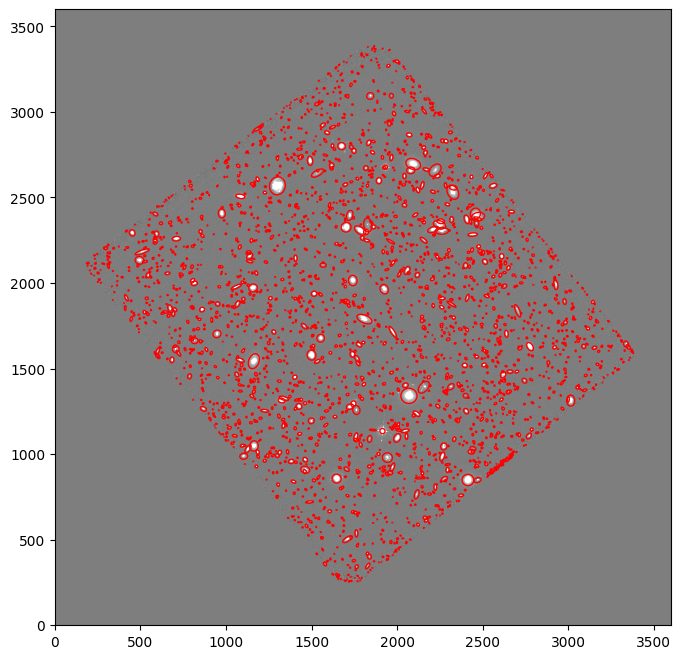

In [30]:
# Plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Create an empty array for the x coordinates of the ellipses
ec = []

# Plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i]*180.0/np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    ec.append(objects['x'][i]) #######################################################
    
plt.savefig("f105w_v1.0_drz_OBJECTS.png", bbox_inches='tight',dpi=800) # Save the image as a .png file

#### objects has many other fields, giving information such as second moments, and peak pixel positions and values. You can see the available fields:

In [31]:
# Available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry
#### Finally we'll perform circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [32]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

#### flux, fluxerr, and flag are all 1D arrays with one entry per object.

In [33]:
# Show the first 10 object results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.029248 +/- 0.171045
object 1: flux = 0.081285 +/- 0.285120
object 2: flux = 0.062260 +/- 0.249537
object 3: flux = 0.069449 +/- 0.263548
object 4: flux = 0.039489 +/- 0.198739
object 5: flux = 0.104682 +/- 0.323559
object 6: flux = 0.040038 +/- 0.200116
object 7: flux = 0.053010 +/- 0.230257
object 8: flux = 0.053288 +/- 0.230859
object 9: flux = 0.042534 +/- 0.206259


## Histogram
#### Now we'll set up a histogram that displays the spread of the objects detected

In [34]:
# Create the histogram bins
width = 0.05
histmin = np.floor(min(flux))
histmax = np.ceil(max(flux))+width

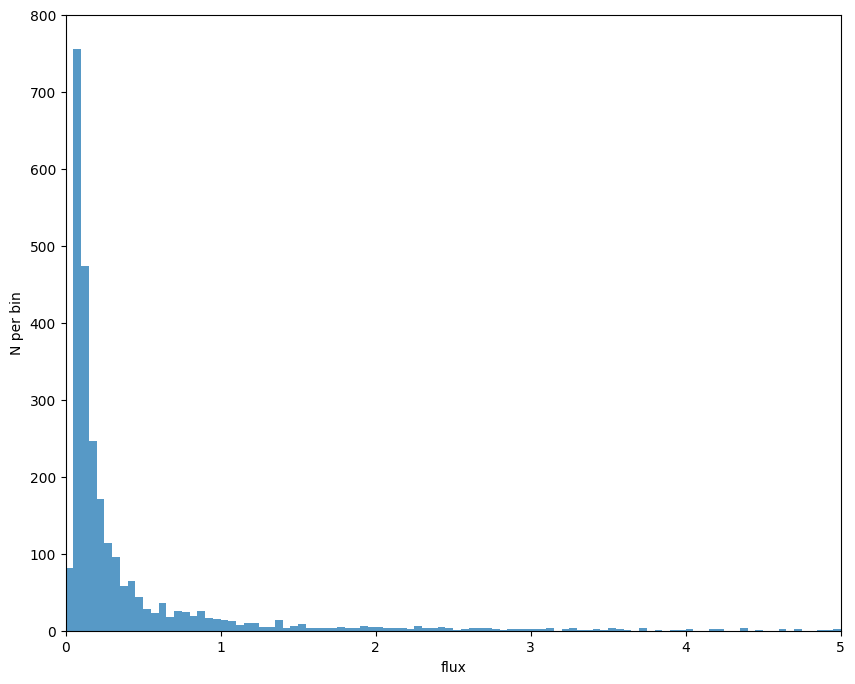

In [35]:
# Print out the histogram
bins = np.arange(histmin, histmax, width)
plt.hist(flux,bins=bins,alpha=0.75,edgecolor="none")
plt.ylim(0,800)
plt.xlim(0,5)
plt.ylabel("N per bin")
plt.xlabel("flux")
plt.savefig("example-histo.png",bbox_inches="tight",facecolor="white",dpi=800)

## Mean, Median, and Standard Deviation
#### In the following cell we shall pull these values from the flux by using preset parts of the program from numpy

In [36]:
# Print out Mean, Median, and Standard Deviation of the Flux
print(f"The flux mean is: {np.mean(flux)}")
print(f"The flux median is: {np.median(flux)}")
print(f"The flux standard deviation is: {np.std(flux)}")

The flux mean is: 1.14359203863266
The flux median is: 0.15093860415276145
The flux standard deviation is: 16.719825460116628


## The Biggest Outlier!
#### Next we identify the most outragous outlier and how many sigma it deviates from the mean

In [37]:
print(f"The Largest Outlier is: {max(flux)}")
print(f"And it is {max(flux)/np.std(flux)} standard deviations away from the mean")

The Largest Outlier is: 807.3367860794068
And it is 48.286197006375644 standard deviations away from the mean


## Creating an RGB False Color Image
#### By combining three images, w160w, f125w, and f105w
##### We start by reading in the data

In [38]:
# Define file names
fdata_F160W = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
fdata_F125W = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_F105W = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

# Read in the data
hdu_2 = fits.open(fdata_F160W)
hdu_3 = fits.open(fdata_F125W)
hdu_4 = fits.open(fdata_F105W)

# Get the image data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

### Scaling the Image Data
#### Data arrays are images with pixel values scaling linearly following the flux of astronomical sources. In order to see a proper image, we need to rescale the data to see faint objects, the following will take care of that.

In [39]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.0
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

### Now let's write a function to quickly plot the rescaled data

In [40]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin,vmax=vpmax)
    plt.savefig("QuickLook.png",bbox_inches='tight',dpi=800)

### Show the image!

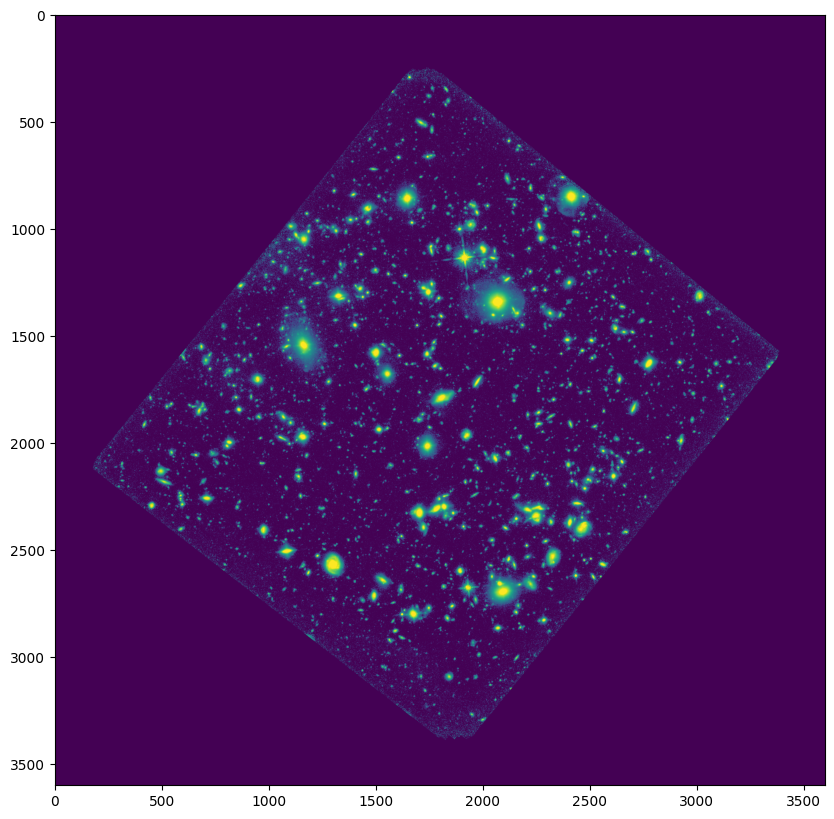

In [41]:
fits_quicklook(data_2)

### Beautiful! Now lets make a 3-color image by using the data from all three images

In [42]:
# Use there rescaled images
data_2_res, d2min, d2max, = rescale_image(data_2)
data_3_res, d3min, d3max, = rescale_image(data_3)
data_4_res, d4min, d4max, = rescale_image(data_4)

### Limit the data to be between the min and max values in the rescaling

In [43]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max] = d3max
data_4_res[data_4_res<d4min] = d4min
data_4_res[data_4_res>d4max] = d4max

### Create an RGB image that is NX x NY x 3 in size, where each image images f160w, f125w, and f105w are R, G, and B respectfully

In [44]:
rgb = np.zeros((data_2_res.shape[0],data_2_res.shape[1],3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

### Plot the RGB image and save it as a PNG file

Ta-Da!!!


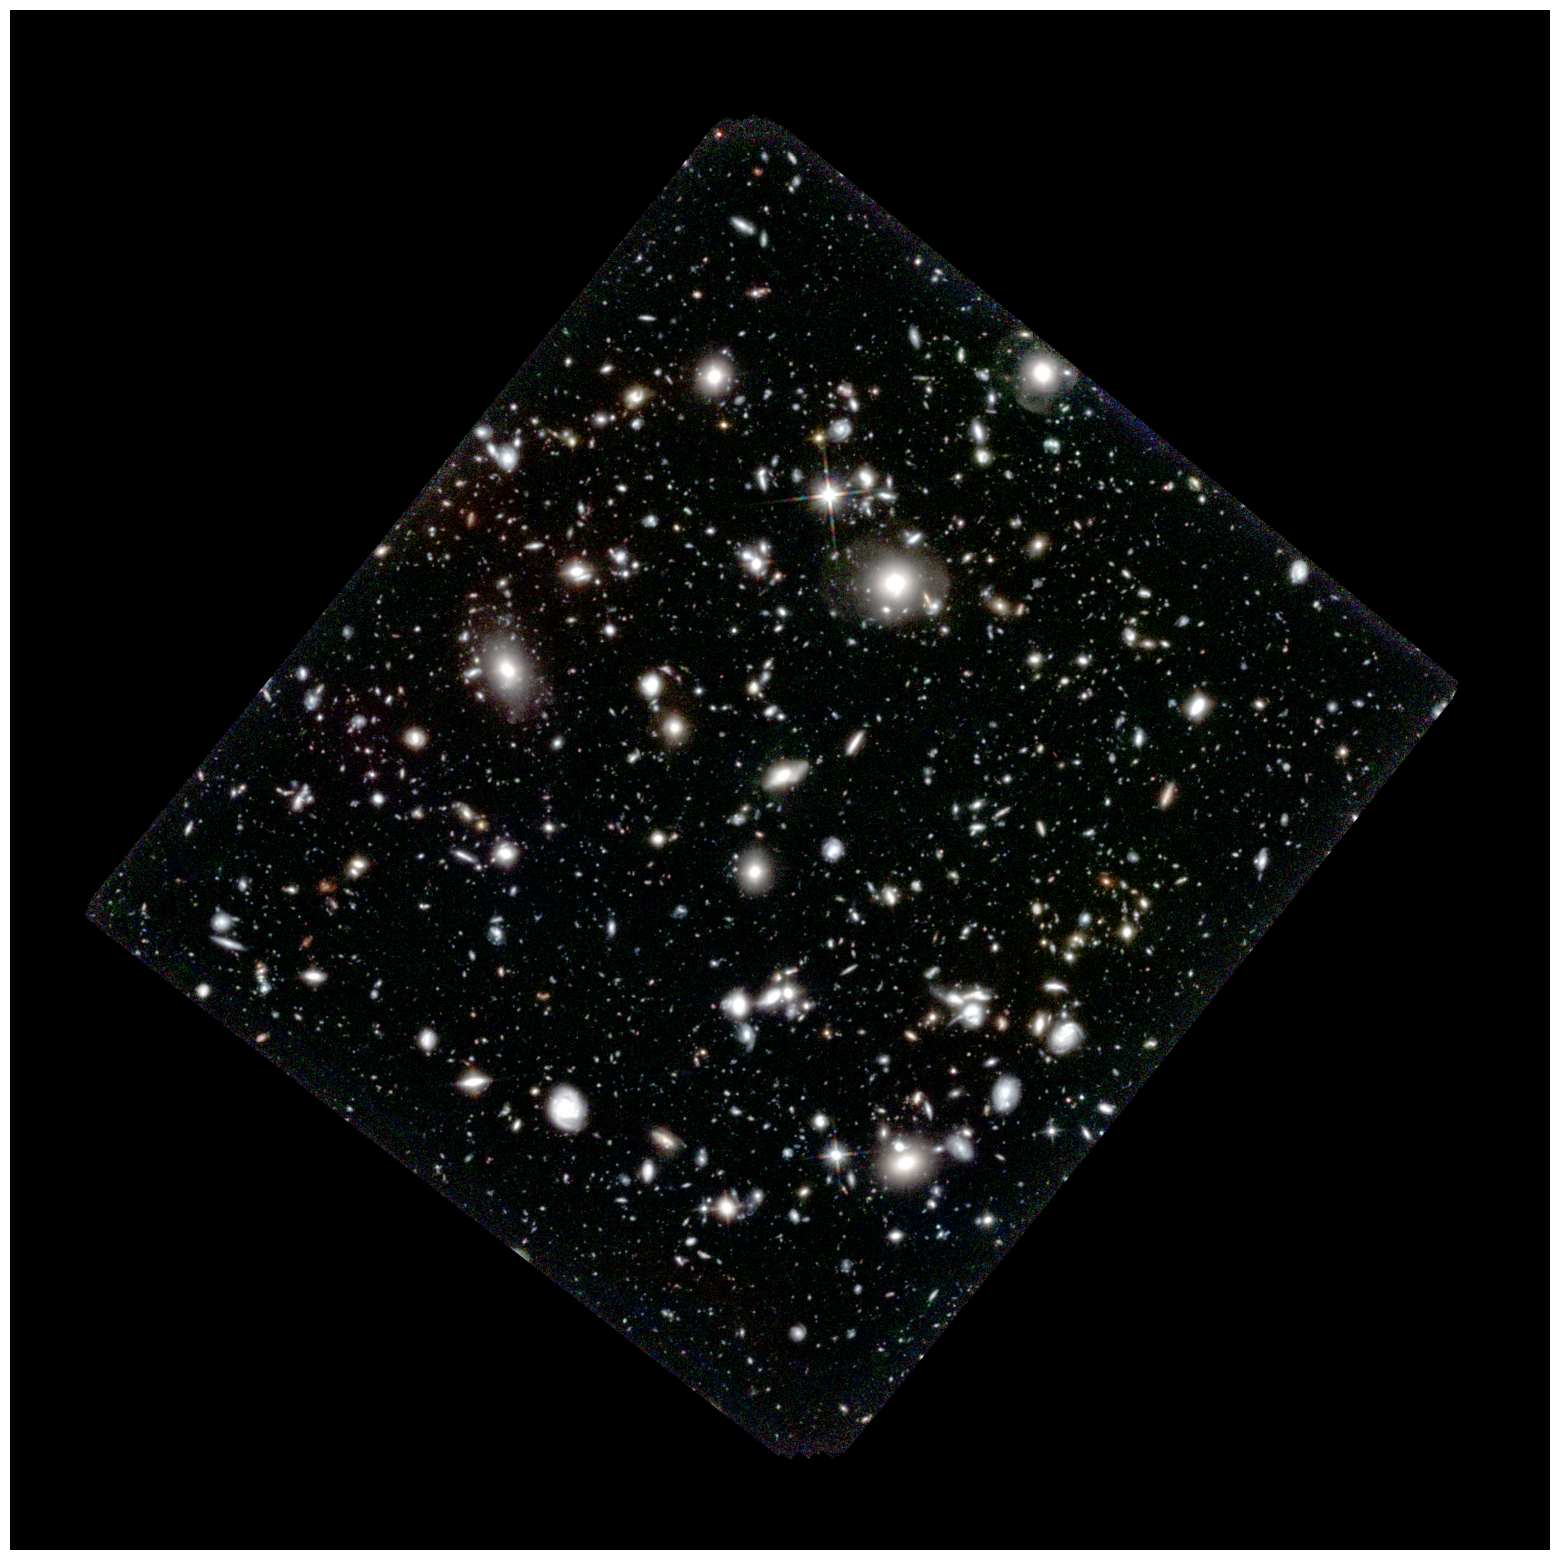

In [45]:
print("Ta-Da!!!")
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('JWST_f160w_f125w_f105W_RGB.png',bbox_inches='tight',pad_inches=0,dpi=800)